# Extreme Value Distributions in Julia 
## Samuel Morris
## ST 810 Final Project

## Introduction

Over the past decade, our ability to answer statistical questions has become reliant on access to computationally efficient software. There are a number of proprietary software packages available (e.g. `SAS`, `Matlab`, `Stata`, and `SPSS`), but these options can be expensive. There are also many open-source software options like `R`, `Python`, and `C`, but these can be computationally inefficient or difficult to learn. More recently `Julia` has gained popularity as a potential contender for an open-source software package that is both easy to learn and computationally efficient. However, one of the drawbacks to a new computing environment is that it lacks some of the packages of a more mature ecosystem like `R`. 

That being said, despite the limited availability of existing packages, `Julia` has the potential to solve some of the challenges with the existing software. To begin with, most of the core functions in the `Julia` language are written using `Julia`. Therefore, once you understand how to write using the `Julia` language, you can also understand the internal working of the software. Code written in `Julia` is generally more computationally efficient than programs like `R`. Finally the syntax of the `Julia` language is very expressive. That is to say, other than a few minor syntactical difference, `Julia` code looks very similar to that written in `R` or `Matlab`. 

This project is meant to be a contribution to the `Julia` ecosystem in the form of a package to work with the generalized extreme value distribution (GEV) and generalized Pareto distribution (GPD). I worked on this package in collaboration with Neal Grantham. His role in the project was to develop the `GeneralizedPareto` type as well as the `fit_mle_optim()` method to fit the GEV and GPD using maximum likelihood methods. My contributions include the `GeneralizedExtremeValue` type as well as the `fit_mcmc()` method that implements an adaptive random walk Metropolis Hastings algorithm to fit the GEV and GPD.

## Generalized extreme value distribution

Many commonly used distributions are available in `Julia` in the `Distributions` package; however, this package does not include either the GEV or GPD. So, before working on methods to fit these distributions, we had to create the distributions in `Julia`. We extended the existing `Distributions` package by creating two new distributions.

```{julia}
GeneralizedExtremeValue <: ContinuousUnivariateDistribution
GeneralizedPareto <: ContinuousUnivariateDistribution
```

In the `Julia` language, the symbol `<:` is used to mean 'is a subtype of'. So, the two distributional types we created are subtypes of the `ContinuousUnivariateDistribution` type found in the `Distributions` package. We have implemented the following methods to use with the `GeneralizedExtremeValue` and `GeneralizedPareto` types.

### Available methods

Let `d` be a distribution of type `GeneralizedExtremeValue` or `GeneralizedPareto`:

#### Parameter retrieval

* `params(d)` returns a tuple of parameters
* `location(d)` returns the location parameter
* `scale(d)` returns the location parameter
* `shape(d)` returns the shape parameter

#### Computation of statistics

* `mean(d)` returns the expectation of distribution `d`
* `var(d)` returns the variance of distribution `d`
* `std(d)` returns the standard deviation of disitribution `d`, i.e. `sqrt(var(d))`
* `median(d)` returns the median value of distribution `d`
* `mode(d)` returns the mode of distribution `d`
* `skewness(d)` returns the skewness of distribution `d`
* `kurtosis(d)` returns the excess kurtosis of distribution `d`
* `entropy(d)` returns the entropy of distribution `d`

#### Probability evaluation

* `insupport(d, x)` returns whether $x$ is within the support of `d`
* `pdf(d, x)` returns the pdf value evaluated at $x$
* `logpdf(d, x)` returns the logarithm of the pdf value evaluated at $x$, i.e. `log(pdf(d, x))`
* `cdf(d, x)` returns the cumulative distribution function evaluated at $x$
* `logcdf(d, x)` returns the logarithm of the cumulative distribution function evaluated at $x$
* `ccdf(d, x)` returns the complementary cumulative function evaluated at $x$, i.e. `1 - cdf(d, x)`
* `logccdf(d, x)` returns the logarithm of the complementary cumulative function evaluated at $x$
* `quantile(d, q)` returns the qth quantile value
* `cquantile(d, q)` returns the complementary quantile value, i.e. `quantile(d, 1 - q)`

#### Sampling (Random number generation)

* `rand(d)` draws a single sample from `d`
* `rand(d, n)` draws a vector comprised of $n$ independent samples from the distribution `d`

## Fitting the distributions with MCMC

We have implemented a random walk metropolis hastings MCMC sampler to fit model parameters for the generalized extreme value distribution (GEV) and generalized Pareto distribution (GPD). We use an adaptive sampler that adjusts the standard deviation of the candidate distribution until the acceptance rate is between 0.25 and 0.50. The method `fit_mcmc()` is used to fit both types of distributions.

### Common interface

Let `y` be an $n \times 1$ vector of responses. The method `fit_mcmc()` is used to fit the GEV or GPD distribution. By default `fit_mcmc(GeneralizedExtremeValue, y)` fits a GEV ($\mu, \sigma, \xi$) distribution to the data, and `fit_mcmc(GeneralizedPareto, y)` fits a GPD ($0, \sigma, \xi$) distribution. Optional named arguments include:

* `Xμ`: matrix of covariates for $\mu$ (Default = `ones(y)`, *GEV only*)
* `μ`: threshold value (Default = `0.0`, *GPD only*)
* `Xσ`: matrix of covariates for $\sigma$ (Default = `ones(y)`)
* `Xξ`: matrix of covariates for $\xi$ (Default = `ones(y)`)
* `βμsd`: prior standard deviation for $\beta$ parameters for $\mu$ (Default = `100.0`, *GEV only*)
* `βσsd`: prior standard deviation for $\beta$ parameters for $\sigma$ (Default = `100.0`)
* `βξsd`: prior standard deviation for $\beta$ parameters for $\xi$ (Default = `1.0`)
* `βμtune`: starting metropolis jump size for candidates $\beta \mu$ (Default = `1.0`, *GEV only*)
* `βσtune`: starting metropolis jump size for candidates $\beta \sigma$ (Default = `1.0`)
* `βξtune`: starting metropolis jump size for candidates $\beta \xi$ (Default = `1.0`)
* `βμseq`: update $\beta$ parameters for $\mu$ sequentially (true) or block (false) (Default = `true`, *GEV only*)
* `βσseq`: update $\beta$ parameters for $\sigma$ sequentially (true) or block (false) (Default = `true`)
* `βξseq`: update $\beta$ parameters for $\sigma$ sequentially (true) or block (false) (Default = `true`)
* `iters`: number of iterations to run the mcmc (Default = `30000`)
* `burn`: length of burnin period (Default = `10000`)
* `thin`: thinning length (Default = `1`)
* `verbose`: do we want to print out periodic updates (Default = `false`)
* `report`: how often to print out updates (Default = `1000`)

The results from fitting the model using MCMC are of type `GeneralizedExtremeValuePosterior` or `GeneralizedParetoPosterior` depending on the type of distribution fit.

#### Missing data

When `y` is a `DataFrame`, then the user can include `NA` values for `fit_mcmc()`. In the current version of the package, `NA` values are assumed to be missing at random and are removed from the dataset.

### Results

Let `results` be a type of `GeneralizedExtremeValuePosterior` or `GeneralizedParetoPosterior`. The full list of available fields is

* `results.y`: Response variable
* `results.ns`: Number of responses per day
* `results.nt`: Number of days
* `results.Xμ`: Covariates for fitting $\mu$ (*GEV only*)
* `results.Xσ`: Covariates for fitting $\sigma$
* `results.Xξ`: Covariates for fitting $\xi$
* `results.βμ`: `MetropolisParameter` type for regression coefficients for $\mu$. (*GEV only*)
* `results.βσ`: `MetropolisParameter` type for regression coefficients for $\sigma$.
* `results.βξ`: `MetropolisParameter` type for regression coefficients for $\xi$.
* `results.βμpost`: Posterior samples for $\beta \mu$ (*GEV only*)
* `results.βσpost`: Posterior samples for $\beta \sigma$
* `results.βξpost`: Posterior samples for $\beta \xi$
* `results.iters`: Number of iterations in the MCMC
* `results.burn`: Length of burnin period
* `results.thin`: How much thinning was used

#### Posterior samples

Posterior samples are available as matrices in `results.βμpost`, `results.βσpost`, and `results.βξpost`. Each iteration is stored as a row in the matrix.

#### MetropolisParameters

The following three results fields are `MetropolisParameter` types: 1) `results.βμ`, 2) `results.βσ`, and 3) `results.βξ`. This type is still under development, but we have included some basic documentation here. The following fields give information about the prior distributions used along with information about final candidate standard deviation and acceptance rates. Here are some of the more useful fields in the `MetropolisParameter` type.

* Post-burnin acceptance rates: `results.βμ.acc ./ results.βμ.att`
* Prior distribution: `results.βμ.prior`
* Sequential update: `results.βμ.seq`

## Simulated data examples

### Generalized extreme value distribution

We generate the following generalized extreme value distribution to demonstrate the capabilities of `fit_mcmc()`. Let

\begin{align} 
Z \sim \text{GEV}(\mu = 1, \sigma = 2, \xi = 0.1)
\end{align}

In [1]:
# generate covariate data and simulated observations
using ExtremeValueDistributions
srand(1000)  # set seed
n = 1000
μ = 1.0
σ = 2.0
ξ = 0.1
y = rand(GeneralizedExtremeValue(μ, σ, ξ), n);

We will fit the data using prior distributions of N(0, 100) for $\mu$ and $\log(\sigma)$, and a prior of N(0, 1) for $\xi$. We use 10000 iterations with a burnin period of 8000.

In [2]:
# fit the model (use arguments verbose = true, report = N to print status updates every N iterations).
results = fit_mcmc(GeneralizedExtremeValue, y, iters=10000, burn=8000);

Looking at the trace plots for the three parameters, it is clear that our MCMC results come back with the correct values.

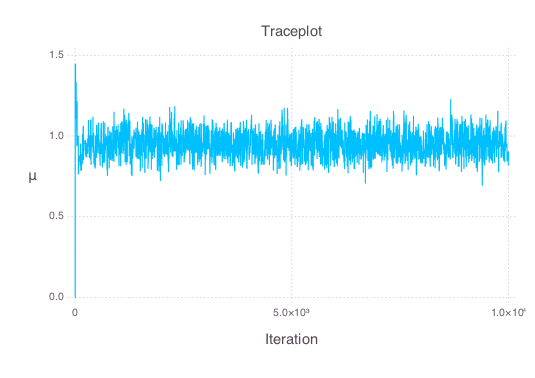

In [3]:
using Gadfly
plot(x = 1:10000, y=results.βμpost, Geom.line, 
     Guide.xlabel("Iteration"), Guide.ylabel("μ"), Guide.title("Traceplot"))

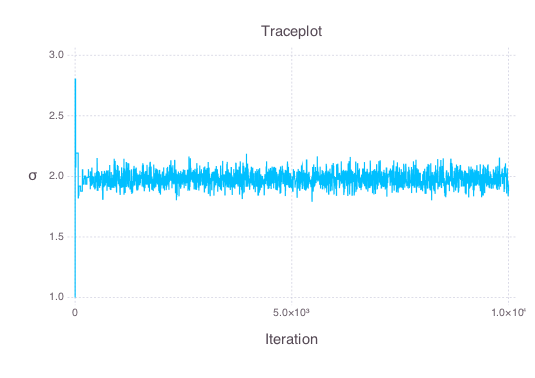

In [4]:
plot(x = 1:10000, y=exp(results.βσpost), Geom.line, 
     Guide.xlabel("Iteration"), Guide.ylabel("σ"), Guide.title("Traceplot"))

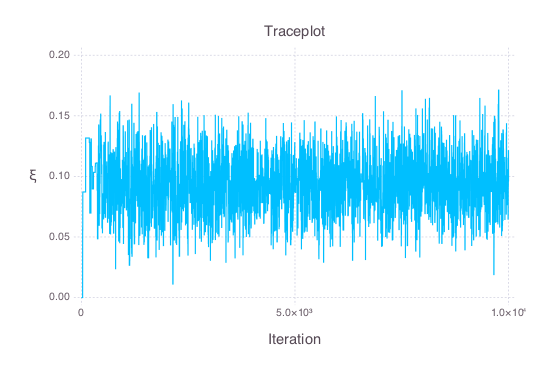

In [5]:
plot(x = 1:10000, y=results.βξpost, Geom.line, 
     Guide.xlabel("Iteration"), Guide.ylabel("ξ"), Guide.title("Traceplot"))

### Generalized Pareto distribution

We can also allow for linear trends in the parameters of the distributions. Let

\begin{align}
Z \sim \text{GPD}(0, \sigma, \xi)
\end{align}

where

\begin{align}
\log(\sigma) &= 2 + 1.3x\\
\xi &= 0.1 \\
X &~\sim N(0, 1) \\
\end{align}

In [6]:
# generate the data
using ExtremeValueDistributions
using Distributions
srand(100)
n  = 1000
X  = hcat(ones(n), rand(Normal(0, 1), n))
βσ = [2.0, 1.3]
σ  = exp(X * βσ)
ξ  = 0.1
y  = [rand(GeneralizedExtremeValue(0.0, σ[i], ξ), 1)[1] for i = 1:n];

We assign independent priors of N(0, 50) for each of the $\beta \sigma$ terms, and a prior of N(0, 1) for $\xi$.

In [7]:
# fit the model
results = fit_mcmc(GeneralizedPareto, y, 0.0, Xσ = X, 
                   βσsd = 50.0, βξsd = 1.0, 
                   βσseq = false, βξseq = false, 
                   iters=10000, burn=8000);

Fitting MCMC using the 608 observations above the threshold.


## Data examples

We have two examples to demonstrate the capabilities of our package to fit a dataset.

### Port Pirie

The dataset `portpirie` consists of annual maximum sea levels (in meters) from Port Pirie, South Australia, from 1928 to 1987. This dataset comes from the `evdbayes` package in `R`. Data can be loaded into `Julia` using `extremedata("portpirie")`.  We fit a GEV using 20000 iterations with a burnin period of 18000. Given that the dataset contains no covariate information, we fit the data assuming a constant location, scale, and shape parameter for all years.

In [8]:
# import the data
  using ExtremeValueDistributions
  df = extremedata("portpirie")
  results = fit_mcmc(GeneralizedExtremeValue, df[:SeaLevel], iters = 20000, burn = 18000);

The traceplots below suggest that the posterior distributions from our package closely mimic the results found from the `evdbayes` package.

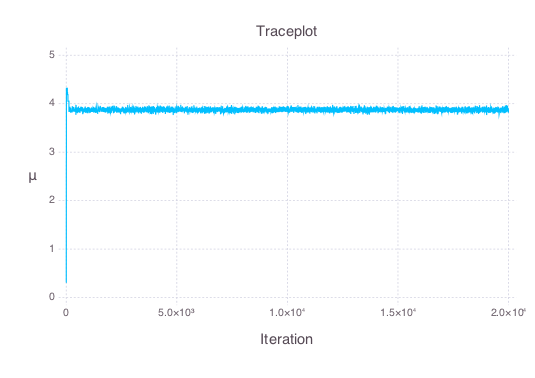

In [9]:
plot(x = 1:20000, y = results.βμpost, Geom.line, 
     Guide.xlabel("Iteration"), Guide.ylabel("μ"), Guide.title("Traceplot"))

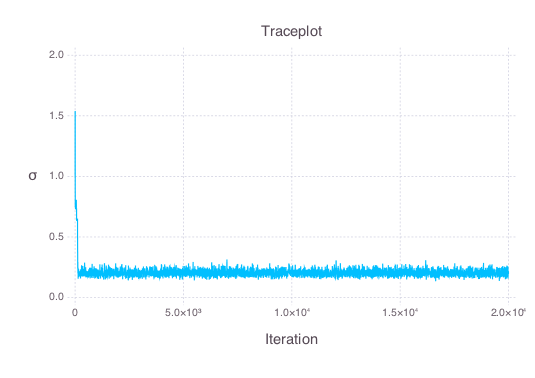

In [10]:
plot(x = 1:20000, y = exp(results.βσpost), Geom.line,
     Guide.xlabel("Iteration"), Guide.ylabel("σ"), Guide.title("Traceplot"))

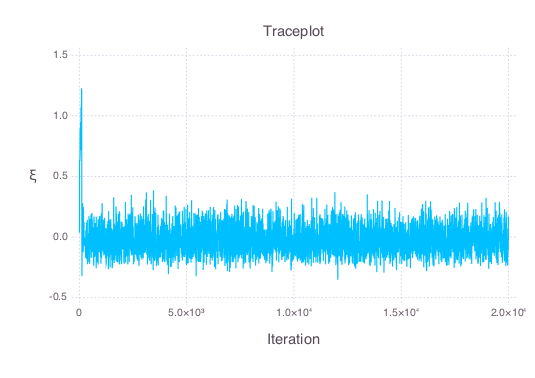

In [11]:
plot(x = 1:20000, y = results.βξpost, Geom.line,
     Guide.xlabel("Iteration"), Guide.ylabel("ξ"), Guide.title("Traceplot"))

### Rainfall in Southern England

The dataset `rainfall` contains 20820 daily rainfall observations (in mm) recorded at a rain gauge in England over 57 years. Three of the years contain only `NA` values, and of the remaining observations 54, are `NA` values. This dataset comes from the `evdbayes` package in `R`. We fit a GPD using 20000 iterations with a burnin period of 18000. As with `portpirie`, the dataset contains no covariate information, so we fit the model assuming a constant scale and shape parameter. As suggested in the `evdbayes` package documentation, we take the threshold to be fixed at 40 mm.

In [12]:
# import the data
using ExtremeValueDistributions
df = extremedata("rainfall")
results = fit_mcmc(GeneralizedPareto, df[:rainfall], 40.0, iters = 20000, burn = 18000);

Keeping 19667 out of 20820 observations. Remaining observations removed due to NA
Fitting MCMC using the 86 observations above the threshold.


Again, the traceplots suggest that the posterior distributions from our package closely mimic the results from the `evdbayes` package.

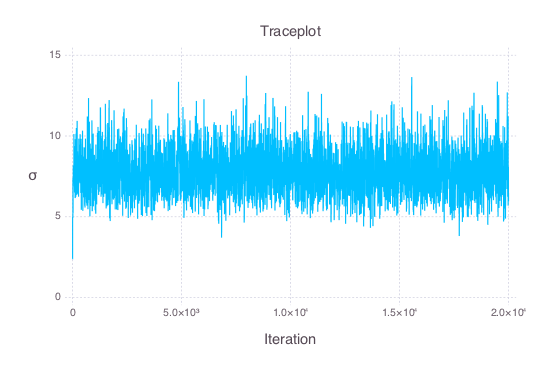

In [13]:
plot(x = 1:20000, y = exp(results.βσpost), Geom.line, 
     Guide.xlabel("Iteration"), Guide.ylabel("σ"), Guide.title("Traceplot"))

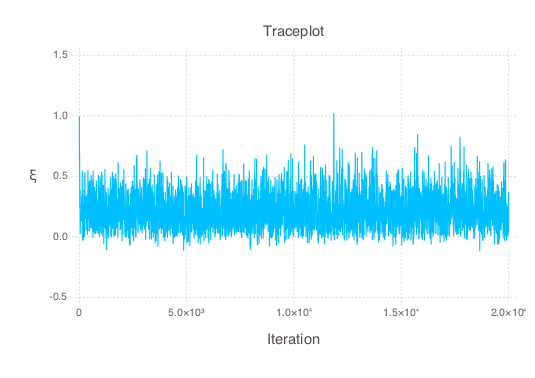

In [14]:
plot(x = 1:20000, y = results.βξpost, Geom.line,
     Guide.xlabel("Iteration"), Guide.ylabel("ξ"), Guide.title("Traceplot"))

## Future work
The functionality of this package is still very basic compared to some of the more mature packages in `R` (e.g. `evdbayes`, `extRemes`). This is in large part due to the fact that we had to develop two new distributional types and the methods for the common interface when working with distributions. I plan to continue working on this package to provide more functionality in a few areas. In particular, this package could benefit from additional functionality to decluster points above a threshold, assign a point process distibutuion, and provide methods for giving return-level estimates. Finally, I plan to eventually include some of the methods that I have been working on for my dissertation research related to spatial binary regression and spatial skew-t methods.

## Bibliography

Alec Stephenson and Mathieu Ribatet. (2014). evdbayes: Bayesian Analysis in Extreme Value Theory. R package version 1.1-1. http://CRAN.R-project.org/package=evdbayes